<a href="https://colab.research.google.com/github/jamessutton600613-png/GC/blob/main/Untitled8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

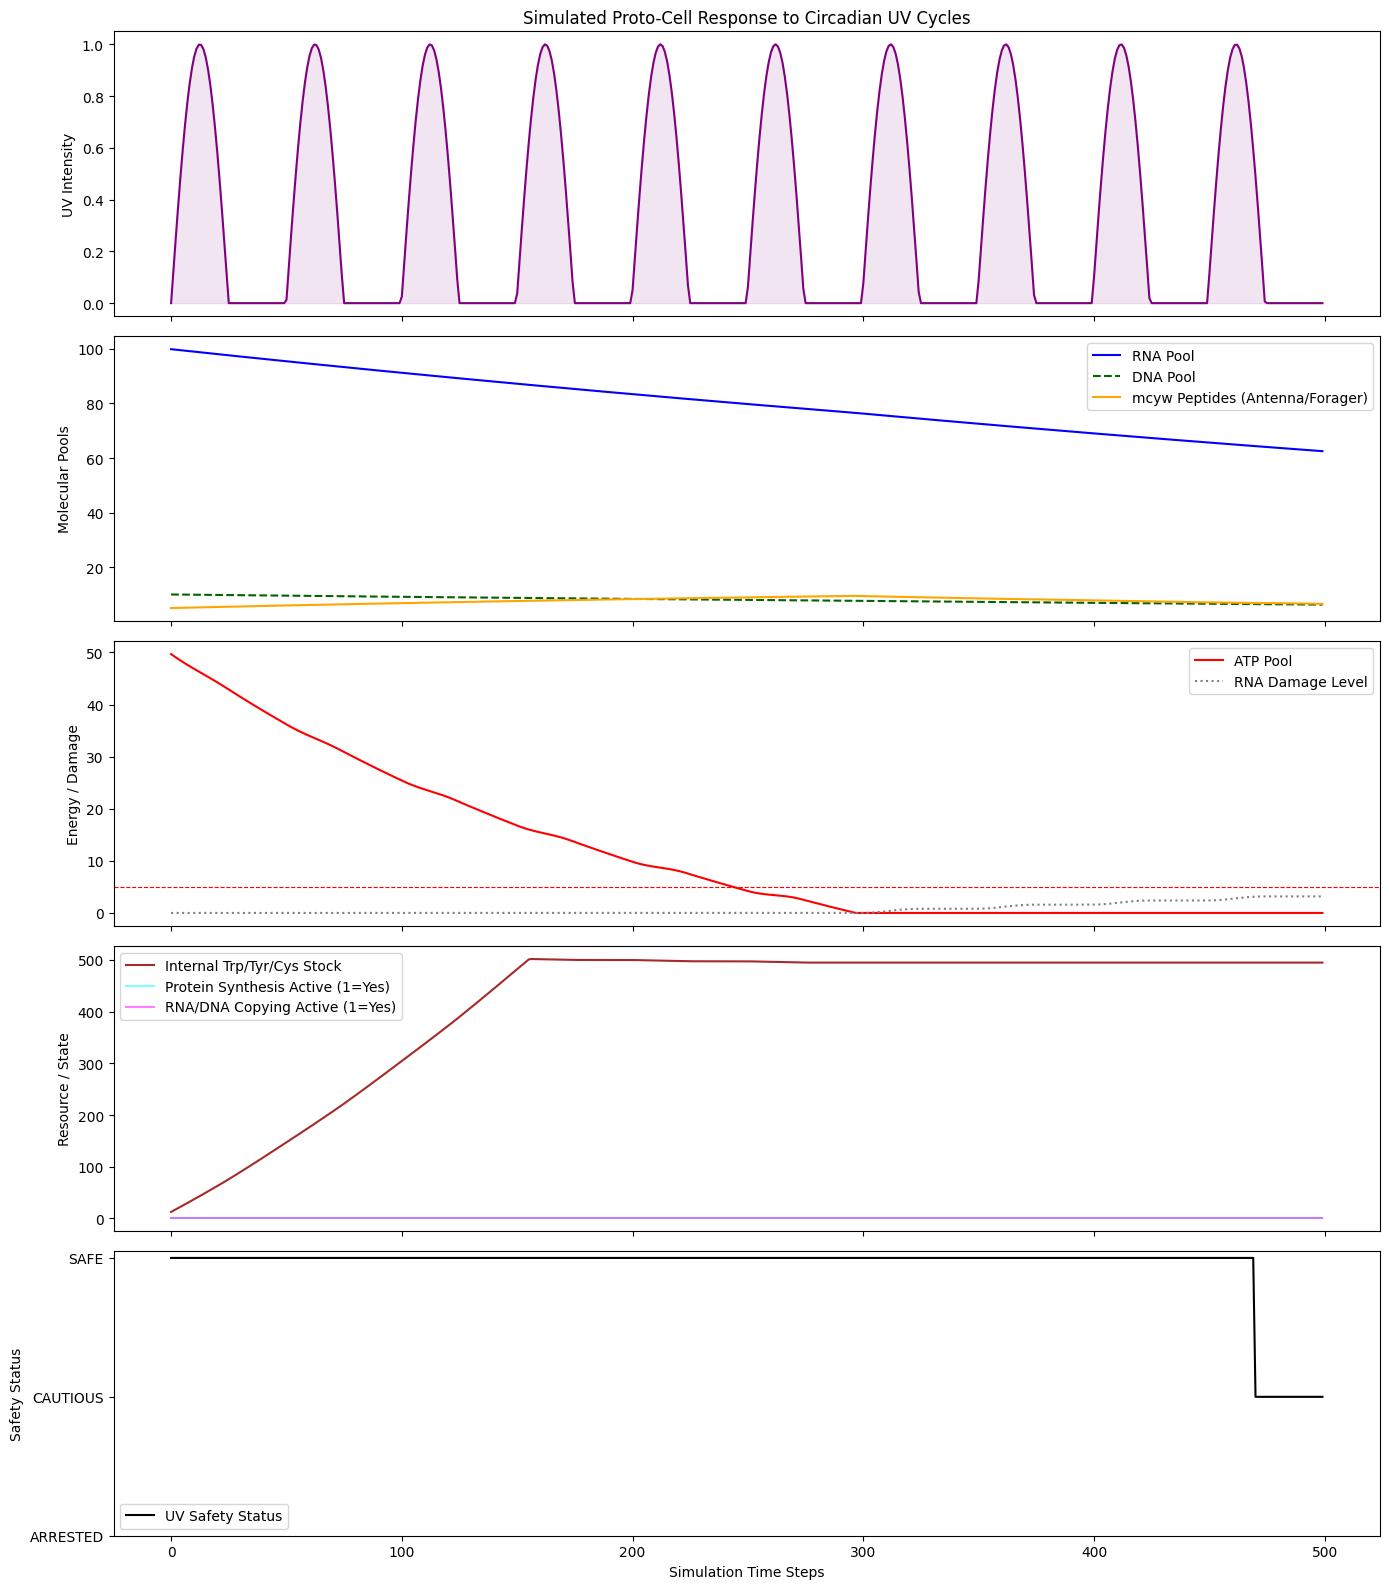

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd # Import pandas for data handling and plotting

# --- 1. Environmental & Global Parameters ---
class Environment:
    def __init__(self, total_sim_steps, days_per_cycle=100):
        self.total_sim_steps = total_sim_steps
        self.days_per_cycle = days_per_cycle # Steps per "day" cycle
        self.time = 0 # Current time step (index)

        # UV Profile (simplified sine wave for circadian cycle)
        # np.linspace creates an array with 'total_sim_steps' points, so indices 0 to total_sim_steps-1
        self.uv_intensity = np.sin(np.linspace(0, 2 * np.pi * (total_sim_steps / days_per_cycle), total_sim_steps))
        self.uv_intensity[self.uv_intensity < 0] = 0 # No negative UV, night is 0

        # --- External Resource Pools (Correctly placed here) ---
        self.external_ntp_pool = 10000.0
        self.external_aa_pool = 10000.0
        self.external_trp_tyr_cys_pool = 500.0 # Scarce, as per hypothesis

    def get_current_uv(self):
        # Ensure we don't go out of bounds at the very end of simulation
        if self.time >= self.total_sim_steps:
            return 0.0 # Return 0 if simulation time somehow exceeds array bounds
        return self.uv_intensity[self.time]

    def step(self):
        self.time += 1
        # Corrected: Use self.days_per_cycle as defined in __init__
        self.current_day_step = self.time % self.days_per_cycle

# --- 2. Proto-Cell/System Class ---
class ProtoCell:
    def __init__(self, env):
        self.env = env

        # Core Molecular Pools (as concentrations/amounts)
        self.rna_pool = 100.0 # General RNA (templates, proto-rRNA)
        self.dna_pool = 10.0  # Basic DNA (more stable template)
        self.atp_pool = 50.0  # Energy currency
        self.mcyw_peptide_pool = 5.0 # Foraging/Antenna peptides
        self.other_peptide_pool = 2.0 # Non-mcyw peptides

        # Resource Stocks (internal to the proto-cell)
        self.internal_ntp_stock = 100.0
        self.internal_aa_stock = 100.0
        self.internal_trp_tyr_cys_stock = 10.0 # Foraged rare AAs

        # System States & Damage
        self.rna_damage_level = 0.0 # Accumulates from UV
        self.protein_synthesis_active = True # Whether ribosomes are active
        self.rna_dna_copying_active = True # Whether replication is active
        self.uv_safety_status = "SAFE" # Based on internal signals
        self.premature_stop_signal = 0.0 # Initialize here, updated in apply_uv_damage

        # --- Parameters (tune these to observe different behaviors) ---
        # UV Damage parameters
        self.uv_damage_rate_per_uv = 0.05 # How much UV damages RNA
        self.damage_tolerance_threshold = 5.0 # Max damage before arrest

        # Foraging parameters (mcyw efficiency, ATP cost, preference for rare AAs)
        self.foraging_efficiency_mcyw = 0.1 # Resource units per mcyw per step
        self.foraging_atp_cost = 0.01 # ATP consumed per foraging action
        self.trp_tyr_cys_foraging_bias = 5.0 # How much more mcyw prioritizes rare AAs

        # Protein Synthesis parameters
        self.protein_synthesis_rate = 0.1 # Peptide units per step (when active)
        self.protein_synthesis_ntp_cost = 0.1
        self.protein_synthesis_aa_cost = 0.1
        self.protein_synthesis_atp_cost = 0.02
        self.mcyw_synthesis_bias = 0.3 # Proportion of protein synthesis making mcyw

        # Stop Codon Precariousness/Signaling
        self.precarious_codon_rate_per_damage = 0.1 # How often damage leads to a premature stop
        self.premature_stop_signal_threshold = 0.5 # Level of signal to trigger arrest

        # ATP Synthesis (from mcyw antenna chains and UV)
        self.atp_generation_rate_per_mcyw_uv = 0.01 # ATP from mcyw in light

        # Repair parameters
        self.repair_rate = 0.05 # How much damage repaired per step
        self.repair_atp_cost = 0.01
        self.trp_tyr_cys_for_repair_needed = 0.1 # Trp/Tyr/Cys consumed for repair

        # RNA/DNA Copying parameters
        self.rna_dna_copy_rate = 0.01 # Rate of template copying
        self.rna_dna_copy_ntp_cost = 0.05
        self.rna_dna_copy_atp_cost = 0.01

        # Degradation rates
        self.rna_degradation_rate = 0.001
        self.peptide_degradation_rate = 0.002
        self.atp_degradation_rate = 0.005

    # --- Core Processes ---
    def _apply_uv_damage(self):
        current_uv = self.env.get_current_uv()
        if current_uv > 0:
            damage_increase = current_uv * self.uv_damage_rate_per_uv
            self.rna_damage_level += damage_increase
            # Simulate the "safety reportage" signal from damaged precarious codons
            self.premature_stop_signal = damage_increase * self.precarious_codon_rate_per_damage
        else:
            self.premature_stop_signal = 0 # No new stops at night

    def _forage(self):
        if self.mcyw_peptide_pool <= 0 or self.atp_pool <= self.foraging_atp_cost:
            return # Cannot forage without mcyw or ATP

        # Consume ATP for foraging movement
        atp_consumed = self.foraging_atp_cost * self.mcyw_peptide_pool
        self.atp_pool -= atp_consumed
        self.atp_pool = max(0, self.atp_pool) # Ensure not negative

        # Acquire general AAs and NTPs from the Environment's external pools
        general_foraged = self.foraging_efficiency_mcyw * self.mcyw_peptide_pool
        transfer_ntp = min(general_foraged / 2, self.env.external_ntp_pool) # Assume half NTP, half AA
        transfer_aa = min(general_foraged / 2, self.env.external_aa_pool)
        self.internal_ntp_stock += transfer_ntp
        self.env.external_ntp_pool -= transfer_ntp
        self.internal_aa_stock += transfer_aa
        self.env.external_aa_pool -= transfer_aa

        # Prioritize rare Trp/Tyr/Cys from the Environment's external pool
        rare_foraged = general_foraged * self.trp_tyr_cys_foraging_bias # Higher efficiency for these
        transfer_rare = min(rare_foraged, self.env.external_trp_tyr_cys_pool)
        self.internal_trp_tyr_cys_stock += transfer_rare
        self.env.external_trp_tyr_cys_pool -= transfer_rare


    def _synthesize_protein(self):
        if not self.protein_synthesis_active:
            return

        required_ntp_base = self.protein_synthesis_ntp_cost
        required_aa_base = self.protein_synthesis_aa_cost
        required_atp_base = self.protein_synthesis_atp_cost

        # Calculate costs for total potential protein synthesis based on current rate
        total_protein_units_to_make = self.protein_synthesis_rate
        total_ntp_cost = total_protein_units_to_make * required_ntp_base
        total_aa_cost = total_protein_units_to_make * required_aa_base
        total_atp_cost = total_protein_units_to_make * required_atp_base

        # Check if enough general resources for ANY protein synthesis
        if self.internal_ntp_stock < total_ntp_cost or \
           self.internal_aa_stock < total_aa_cost or \
           self.atp_pool < total_atp_cost:
            return # Not enough general resources to make any protein

        # Determine how much mcyw vs other peptides can be made
        mcyw_units_possible = 0

        # If Trp/Tyr/Cys are available, try to make mcyw
        if self.internal_trp_tyr_cys_stock > 0 and self.mcyw_synthesis_bias > 0:
            # mcyw costs from both rare and general AA pools (simplified proportion)
            rare_aa_cost_per_mcyw_unit = required_aa_base * self.mcyw_synthesis_bias
            general_aa_cost_per_mcyw_unit = required_aa_base * (1 - self.mcyw_synthesis_bias) # Remaining AA cost

            # Max mcyw units based on rare AAs
            max_mcyw_from_rare_aa = self.internal_trp_tyr_cys_stock / rare_aa_cost_per_mcyw_unit if rare_aa_cost_per_mcyw_unit > 0 else float('inf')
            # Max mcyw units based on general AAs (mcyw also consumes general AAs)
            max_mcyw_from_general_aa = self.internal_aa_stock / general_aa_cost_per_mcyw_unit if general_aa_cost_per_mcyw_unit > 0 else float('inf')

            mcyw_units_possible = min(total_protein_units_to_make * self.mcyw_synthesis_bias, max_mcyw_from_rare_aa, max_mcyw_from_general_aa)

        other_units_possible = total_protein_units_to_make - mcyw_units_possible

        # Adjust actual synthesis based on what's possible and available
        actual_mcyw_made = mcyw_units_possible
        actual_other_made = other_units_possible

        # Consume resources for mcyw
        if actual_mcyw_made > 0:
            self.internal_trp_tyr_cys_stock -= actual_mcyw_made * rare_aa_cost_per_mcyw_unit if self.mcyw_synthesis_bias > 0 else 0
            self.internal_aa_stock -= actual_mcyw_made * general_aa_cost_per_mcyw_unit if self.mcyw_synthesis_bias > 0 else 0
            self.mcyw_peptide_pool += actual_mcyw_made

        # Consume resources for other peptides
        self.internal_ntp_stock -= actual_other_made * required_ntp_base
        self.internal_aa_stock -= actual_other_made * required_aa_base
        self.other_peptide_pool += actual_other_made

        self.atp_pool -= total_atp_cost # Total ATP cost for all synthesis

        # Ensure pools don't go negative
        self.internal_ntp_stock = max(0, self.internal_ntp_stock)
        self.internal_aa_stock = max(0, self.internal_aa_stock)
        self.internal_trp_tyr_cys_stock = max(0, self.internal_trp_tyr_cys_stock)
        self.atp_pool = max(0, self.atp_pool)

    def _synthesize_atp(self):
        current_uv = self.env.get_current_uv()
        if current_uv > 0 and self.mcyw_peptide_pool > 0:
            atp_generated = self.atp_generation_rate_per_mcyw_uv * self.mcyw_peptide_pool * current_uv
            self.atp_pool += atp_generated

    def _repair_rna_dna(self):
        if self.rna_damage_level > 0:
            required_atp = self.repair_atp_cost
            required_trp_tyr_cys = self.trp_tyr_cys_for_repair_needed # Trp/Tyr/Cys needed for repair "enzymes" / structural roles

            if self.atp_pool >= required_atp and self.internal_trp_tyr_cys_stock >= required_trp_tyr_cys:
                self.atp_pool -= required_atp
                self.internal_trp_tyr_cys_stock -= required_trp_tyr_cys

                repaired_amount = min(self.rna_damage_level, self.repair_rate)
                self.rna_damage_level -= repaired_amount

                self.atp_pool = max(0, self.atp_pool)
                self.internal_trp_tyr_cys_stock = max(0, self.internal_trp_tyr_cys_stock)

    def _copy_rna_dna(self):
        if not self.rna_dna_copying_active:
            return

        required_ntp = self.rna_dna_copy_ntp_cost
        required_atp = self.rna_dna_copy_atp_cost

        if self.internal_ntp_stock >= required_ntp and self.atp_pool >= required_atp:
            self.internal_ntp_stock -= required_ntp
            self.atp_pool -= required_atp

            # Simplified growth: just increase RNA/DNA pool
            self.rna_pool += self.rna_dna_copy_rate * 0.9 # More RNA copies
            self.dna_pool += self.rna_dna_copy_rate * 0.1 # Less DNA copies, for stability

            self.internal_ntp_stock = max(0, self.internal_ntp_stock)
            self.atp_pool = max(0, self.atp_pool)


    def _degrade(self):
        self.rna_pool *= (1 - self.rna_degradation_rate)
        self.dna_pool *= (1 - self.rna_degradation_rate) # DNA degrades slower, simplified
        self.mcyw_peptide_pool *= (1 - self.peptide_degradation_rate)
        self.other_peptide_pool *= (1 - self.peptide_degradation_rate)
        self.atp_pool *= (1 - self.atp_degradation_rate)

        # Ensure pools don't go negative due to degradation
        self.rna_pool = max(0, self.rna_pool)
        self.dna_pool = max(0, self.dna_pool)
        self.mcyw_peptide_pool = max(0, self.mcyw_peptide_pool)
        self.other_peptide_pool = max(0, self.other_peptide_pool)
        self.atp_pool = max(0, self.atp_pool)


    def _manage_state(self):
        # 1. Evaluate UV Safety Signal (Safety Reportage)
        # Signal is high if damage is high OR rare AAs (Trp/Tyr/Cys) are low
        # Normalize damage to a 0-1 scale relative to threshold for signal contribution
        normalized_damage_signal = min(1.0, self.rna_damage_level / self.damage_tolerance_threshold)

        # Signal from Trp/Tyr/Cys scarcity (inverse relationship: lower stock = higher signal)
        # Assuming required_trp_tyr_cys is a baseline need per repair/synthesis cycle
        # If stock is below 5x needed for repair, it contributes to signal
        trp_tyr_cys_scarcity_signal = 0.0
        # Only check scarcity as a signal during daylight, when protection is needed
        if self.internal_trp_tyr_cys_stock < self.trp_tyr_cys_for_repair_needed * 5 and self.env.get_current_uv() > 0.1:
            trp_tyr_cys_scarcity_signal = 1.0 - (self.internal_trp_tyr_cys_stock / (self.trp_tyr_cys_for_repair_needed * 5))
            trp_tyr_cys_scarcity_signal = max(0, min(1, trp_tyr_cys_scarcity_signal)) # Clamp between 0 and 1

        # Total premature stop signal (weighted by UV intensity during day)
        current_stop_signal = self.premature_stop_signal * self.env.get_current_uv() # Signal only relevant when UV is present

        # Overall "Danger" Metric
        danger_metric = (normalized_damage_signal * 0.4) + \
                        (trp_tyr_cys_scarcity_signal * 0.4) + \
                        (current_stop_signal * 0.2) # Weight contributions

        # 2. Decision: "Cell Cycle Arrest" (Protein Synthesis and RNA/DNA Copying)
        if danger_metric >= self.premature_stop_signal_threshold:
            self.protein_synthesis_active = False
            self.rna_dna_copying_active = False
            self.uv_safety_status = "ARRESTED - HIGH DAMAGE/LOW PROTECTION"
        # Resume only if danger is low AND resources (including protection) are sufficient
        elif danger_metric < self.premature_stop_signal_threshold * 0.5 and \
             self.internal_trp_tyr_cys_stock > self.trp_tyr_cys_for_repair_needed * 10: # More robust threshold for resuming
            self.protein_synthesis_active = True
            self.rna_dna_copying_active = True
            self.uv_safety_status = "SAFE - GROWING"
        else:
             self.uv_safety_status = "CAUTIOUS"


    def step(self):
        # 1. Apply environmental influences
        self._apply_uv_damage()
        self._synthesize_atp() # From mcyw antenna chains

        # 2. Proto-cell internal processes (order matters for dependencies)
        self._forage() # mcyw consumes ATP, gets resources
        self._repair_rna_dna() # Consumes ATP, rare AAs, reduces damage
        self._manage_state() # Decides whether to synthesize/copy

        # 3. Protein and Nucleic Acid Synthesis (gated by _manage_state)
        self._synthesize_protein() # Makes mcyw and other peptides
        self._copy_rna_dna() # Replicates RNA/DNA

        # 4. Degradation
        self._degrade()


# --- 3. Simulation Runner ---
def run_simulation(total_steps=500, days_per_cycle=50):
    env = Environment(total_steps, days_per_cycle)
    cell = ProtoCell(env) # Pass env to cell

    # --- Data Collection for Visualization ---
    data = {
        'time': [],
        'uv_intensity': [],
        'rna_pool': [],
        'dna_pool': [],
        'atp_pool': [],
        'mcyw_peptide_pool': [],
        'rna_damage_level': [],
        'uv_safety_status': [],
        'internal_trp_tyr_cys_stock': [],
        'protein_synthesis_active': [],
        'rna_dna_copying_active': []
    }

    for _ in range(total_steps):
        # Capture current UV before any time advancement for consistent data point
        current_uv_value = env.get_current_uv()

        # Advance cell state for this step
        cell.step()

        # Store data for this step (using the env.time *before* env.step() increments it)
        data['time'].append(env.time)
        data['uv_intensity'].append(current_uv_value)
        data['rna_pool'].append(cell.rna_pool)
        data['dna_pool'].append(cell.dna_pool)
        data['atp_pool'].append(cell.atp_pool)
        data['mcyw_peptide_pool'].append(cell.mcyw_peptide_pool)
        data['rna_damage_level'].append(cell.rna_damage_level)
        data['uv_safety_status'].append(cell.uv_safety_status)
        data['internal_trp_tyr_cys_stock'].append(cell.internal_trp_tyr_cys_stock)
        data['protein_synthesis_active'].append(1 if cell.protein_synthesis_active else 0)
        data['rna_dna_copying_active'].append(1 if cell.rna_dna_copying_active else 0)

        # Advance environment to the *next* time step
        env.step()

    # Return the collected data
    return data

# --- Run the Simulation ---
if __name__ == "__main__":
    simulation_results = run_simulation(total_steps=500, days_per_cycle=50) # Simulate for 10 "days"

    # Convert results to a pandas DataFrame for easier plotting
    results_df = pd.DataFrame(simulation_results)

    # --- 4. Visualization ---
    fig, axs = plt.subplots(5, 1, figsize=(14, 16), sharex=True)

    # UV Intensity
    axs[0].plot(results_df['time'], results_df['uv_intensity'], color='purple')
    axs[0].set_ylabel('UV Intensity')
    axs[0].set_title('Simulated Proto-Cell Response to Circadian UV Cycles')
    axs[0].fill_between(results_df['time'], 0, results_df['uv_intensity'], color='purple', alpha=0.1)

    # Nucleic Acid & Peptide Pools
    axs[1].plot(results_df['time'], results_df['rna_pool'], label='RNA Pool', color='blue')
    axs[1].plot(results_df['time'], results_df['dna_pool'], label='DNA Pool', color='darkgreen', linestyle='--')
    axs[1].plot(results_df['time'], results_df['mcyw_peptide_pool'], label='mcyw Peptides (Antenna/Forager)', color='orange')
    axs[1].set_ylabel('Molecular Pools')
    axs[1].legend()

    # ATP and Damage
    axs[2].plot(results_df['time'], results_df['atp_pool'], label='ATP Pool', color='red')
    axs[2].plot(results_df['time'], results_df['rna_damage_level'], label='RNA Damage Level', color='grey', linestyle=':')
    axs[2].set_ylabel('Energy / Damage')
    axs[2].legend()
    # Access the threshold from a ProtoCell instance or define it for plotting
    # We can create a dummy ProtoCell instance just to get its parameter for plotting clarity
    dummy_cell_for_param = ProtoCell(Environment(1,1)) # Needs a dummy env
    axs[2].axhline(y=dummy_cell_for_param.damage_tolerance_threshold, color='red', linestyle='--', linewidth=0.8, label='Damage Tolerance Threshold')

    # Rare AA Stock and System Activity
    axs[3].plot(results_df['time'], results_df['internal_trp_tyr_cys_stock'], label='Internal Trp/Tyr/Cys Stock', color='brown')
    axs[3].plot(results_df['time'], results_df['protein_synthesis_active'], label='Protein Synthesis Active (1=Yes)', color='cyan', alpha=0.5)
    axs[3].plot(results_df['time'], results_df['rna_dna_copying_active'], label='RNA/DNA Copying Active (1=Yes)', color='magenta', alpha=0.5)
    axs[3].set_ylabel('Resource / State')
    axs[3].legend()

    # UV Safety Status
    status_map = {"SAFE - GROWING": 1, "CAUTIOUS": 0.5, "ARRESTED - HIGH DAMAGE/LOW PROTECTION": 0}
    status_numeric = [status_map[s] for s in results_df['uv_safety_status']]
    axs[4].plot(results_df['time'], status_numeric, label='UV Safety Status', color='black')
    axs[4].set_ylabel('Safety Status')
    axs[4].set_yticks([0, 0.5, 1])
    axs[4].set_yticklabels(["ARRESTED", "CAUTIOUS", "SAFE"])
    axs[4].set_xlabel('Simulation Time Steps')
    axs[4].legend()

    plt.tight_layout()
    plt.show()



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd # Import pandas for data handling and plotting

# --- 1. Environmental & Global Parameters ---
class Environment:
    def __init__(self, total_sim_steps, days_per_cycle=100):
            self.total_sim_steps = total_sim_steps
                    self.days_per_cycle = days_per_cycle # Steps per "day" cycle
                            self.time = 0 # Current time step (index)

                                    # UV Profile (simplified sine wave for circadian cycle)
                                            # np.linspace creates an array with 'total_sim_steps' points, so indices 0 to total_sim_steps-1
                                                    self.uv_intensity = np.sin(np.linspace(0, 2 * np.pi * (total_sim_steps / days_per_cycle), total_sim_steps))
                                                            self.uv_intensity[self.uv_intensity < 0] = 0 # No negative UV, night is 0

                                                                    # --- External Resource Pools (Correctly placed here) ---
                                                                            self.external_ntp_pool = 10000.0
                                                                                    self.external_aa_pool = 10000.0
                                                                                            self.external_trp_tyr_cys_pool = 500.0 # Scarce, as per hypothesis

                                                                                                def get_current_uv(self):
                                                                                                        # Ensure we don't go out of bounds at the very end of simulation
                                                                                                                if self.time >= self.total_sim_steps:
                                                                                                                            return 0.0 # Return 0 if simulation time somehow exceeds array bounds
                                                                                                                                    return self.uv_intensity[self.time]

                                                                                                                                        def step(self):
                                                                                                                                                self.time += 1
                                                                                                                                                        # Corrected: Use self.days_per_cycle as defined in __init__
                                                                                                                                                                self.current_day_step = self.time % self.days_per_cycle

                                                                                                                                                                # --- 2. Proto-Cell/System Class ---
                                                                                                                                                                class ProtoCell:
                                                                                                                                                                    def __init__(self, env):
                                                                                                                                                                            self.env = env

                                                                                                                                                                                    # Core Molecular Pools (as concentrations/amounts)
                                                                                                                                                                                            self.rna_pool = 100.0 # General RNA (templates, proto-rRNA)
                                                                                                                                                                                                    self.dna_pool = 10.0  # Basic DNA (more stable template)
                                                                                                                                                                                                            self.atp_pool = 50.0  # Energy currency
                                                                                                                                                                                                                    self.mcyw_peptide_pool = 5.0 # Foraging/Antenna peptides
                                                                                                                                                                                                                            self.other_peptide_pool = 2.0 # Non-mcyw peptides

                                                                                                                                                                                                                                    # Resource Stocks (internal to the proto-cell)
                                                                                                                                                                                                                                            self.internal_ntp_stock = 100.0
                                                                                                                                                                                                                                                    self.internal_aa_stock = 100.0
                                                                                                                                                                                                                                                            self.internal_trp_tyr_cys_stock = 10.0 # Foraged rare AAs

                                                                                                                                                                                                                                                                    # System States & Damage
                                                                                                                                                                                                                                                                            self.rna_damage_level = 0.0 # Accumulates from UV
                                                                                                                                                                                                                                                                                    self.protein_synthesis_active = True # Whether ribosomes are active
                                                                                                                                                                                                                                                                                            self.rna_dna_copying_active = True # Whether replication is active
                                                                                                                                                                                                                                                                                                    self.uv_safety_status = "SAFE" # Based on internal signals
                                                                                                                                                                                                                                                                                                            self.premature_stop_signal = 0.0 # Initialize here, updated in apply_uv_damage

                                                                                                                                                                                                                                                                                                                    # --- Parameters (tuned for clearer "Safety Reportage" behavior) ---
                                                                                                                                                                                                                                                                                                                            # UV Damage parameters
                                                                                                                                                                                                                                                                                                                                    self.uv_damage_rate_per_uv = 0.15 # INCREASE: Make UV more damaging (was 0.05)
                                                                                                                                                                                                                                                                                                                                            self.damage_tolerance_threshold = 4.0 # DECREASE: Make the threshold for arrest lower (was 5.0)

                                                                                                                                                                                                                                                                                                                                                    # Foraging parameters (mcyw efficiency, ATP cost, preference for rare AAs)
                                                                                                                                                                                                                                                                                                                                                            self.foraging_efficiency_mcyw = 0.12 # SLIGHTLY INCREASE: (was 0.1)
                                                                                                                                                                                                                                                                                                                                                                    self.foraging_atp_cost = 0.008 # DECREASE: Make foraging slightly cheaper (was 0.01)
                                                                                                                                                                                                                                                                                                                                                                            self.trp_tyr_cys_foraging_bias = 7.0 # INCREASE: Make foraging for rare AAs even more biased (was 5.0)

                                                                                                                                                                                                                                                                                                                                                                                    # Protein Synthesis parameters
                                                                                                                                                                                                                                                                                                                                                                                            self.protein_synthesis_rate = 0.1 # Keep as is
                                                                                                                                                                                                                                                                                                                                                                                                    self.protein_synthesis_ntp_cost = 0.1
                                                                                                                                                                                                                                                                                                                                                                                                            self.protein_synthesis_aa_cost = 0.1
                                                                                                                                                                                                                                                                                                                                                                                                                    self.protein_synthesis_atp_cost = 0.02 # Keep as is
                                                                                                                                                                                                                                                                                                                                                                                                                            self.mcyw_synthesis_bias = 0.4 # INCREASE: Prioritize making more mcyw (was 0.3)
                                                                                                                                                                                                                                                                                                                                                                                                                                                                   # Crucial for both ATP generation AND foraging for rare AAs

                                                                                                                                                                                                                                                                                                                                                                                                                                                                           # Stop Codon Precariousness/Signaling
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   self.precarious_codon_rate_per_damage = 0.2 # INCREASE: Make damage-induced stops more potent (was 0.1)
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           self.premature_stop_signal_threshold = 0.4 # DECREASE: Make the trigger for arrest more sensitive (was 0.5)

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   # ATP Synthesis (from mcyw antenna chains and UV)
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           self.atp_generation_rate_per_mcyw_uv = 0.03 # INCREASE: Make ATP generation more efficient (was 0.01)
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               # Vital to prevent quick energy collapse

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       # Repair parameters
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               self.repair_rate = 0.1 # INCREASE: Make repair faster (was 0.05)
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       self.repair_atp_cost = 0.01
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               self.trp_tyr_cys_for_repair_needed = 0.1 # Keep as is

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       # RNA/DNA Copying parameters
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               self.rna_dna_copy_rate = 0.02 # INCREASE: Allow for more significant growth (was 0.01)
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       self.rna_dna_copy_ntp_cost = 0.05
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               self.rna_dna_copy_atp_cost = 0.01

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       # Degradation rates
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               self.rna_degradation_rate = 0.001
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       self.peptide_degradation_rate = 0.002
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               self.atp_degradation_rate = 0.005

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   # --- Core Processes ---
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       def _apply_uv_damage(self):
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               current_uv = self.env.get_current_uv()
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       if current_uv > 0:
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   damage_increase = current_uv * self.uv_damage_rate_per_uv
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               self.rna_damage_level += damage_increase
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           # Simulate the "safety reportage" signal from damaged precarious codons
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       self.premature_stop_signal = damage_increase * self.precarious_codon_rate_per_damage
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               else:
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           self.premature_stop_signal = 0 # No new stops at night

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               def _forage(self):
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       if self.mcyw_peptide_pool <= 0 or self.atp_pool <= self.foraging_atp_cost:
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   return # Cannot forage without mcyw or ATP

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           # Consume ATP for foraging movement
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   atp_consumed = self.foraging_atp_cost * self.mcyw_peptide_pool
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           self.atp_pool -= atp_consumed
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   self.atp_pool = max(0, self.atp_pool) # Ensure not negative

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           # Acquire general AAs and NTPs from the Environment's external pools
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   general_foraged = self.foraging_efficiency_mcyw * self.mcyw_peptide_pool
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           transfer_ntp = min(general_foraged / 2, self.env.external_ntp_pool) # Assume half NTP, half AA
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   transfer_aa = min(general_foraged / 2, self.env.external_aa_pool)
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           self.internal_ntp_stock += transfer_ntp
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   self.env.external_ntp_pool -= transfer_ntp
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           self.internal_aa_stock += transfer_aa
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   self.env.external_aa_pool -= transfer_aa

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           # Prioritize rare Trp/Tyr/Cys from the Environment's external pool
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   rare_foraged = general_foraged * self.trp_tyr_cys_foraging_bias # Higher efficiency for these
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           transfer_rare = min(rare_foraged, self.env.external_trp_tyr_cys_pool)
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   self.internal_trp_tyr_cys_stock += transfer_rare
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           self.env.external_trp_tyr_cys_pool -= transfer_rare


                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               def _synthesize_protein(self):
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       if not self.protein_synthesis_active:
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   return

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           required_ntp_base = self.protein_synthesis_ntp_cost
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   required_aa_base = self.protein_synthesis_aa_cost
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           required_atp_base = self.protein_synthesis_atp_cost

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   # Calculate costs for total potential protein synthesis based on current rate
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           total_protein_units_to_make = self.protein_synthesis_rate
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   total_ntp_cost = total_protein_units_to_make * required_ntp_base
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           total_aa_cost = total_protein_units_to_make * required_aa_base
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   total_atp_cost = total_protein_units_to_make * required_atp_base

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           # Check if enough general resources for ANY protein synthesis
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   if self.internal_ntp_stock < total_ntp_cost or \
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              self.internal_aa_stock < total_aa_cost or \
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         self.atp_pool < total_atp_cost:
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     return # Not enough general resources to make any protein

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             # Determine how much mcyw vs other peptides can be made
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     mcyw_units_possible = 0

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     # If Trp/Tyr/Cys are available, try to make mcyw
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             if self.internal_trp_tyr_cys_stock > 0 and self.mcyw_synthesis_bias > 0:
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         # mcyw costs from both rare and general AA pools (simplified proportion)
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     rare_aa_cost_per_mcyw_unit = required_aa_base * self.mcyw_synthesis_bias
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 general_aa_cost_per_mcyw_unit = required_aa_base * (1 - self.mcyw_synthesis_bias) # Remaining AA cost

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             # Max mcyw units based on rare AAs
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         max_mcyw_from_rare_aa = self.internal_trp_tyr_cys_stock / rare_aa_cost_per_mcyw_unit if rare_aa_cost_per_mcyw_unit > 0 else float('inf')
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     # Max mcyw units based on general AAs (mcyw also consumes general AAs)
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 max_mcyw_from_general_aa = self.internal_aa_stock / general_aa_cost_per_mcyw_unit if general_aa_cost_per_mcyw_unit > 0 else float('inf')

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             mcyw_units_possible = min(total_protein_units_to_make * self.mcyw_synthesis_bias, max_mcyw_from_rare_aa, max_mcyw_from_general_aa)

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 other_units_possible = total_protein_units_to_make - mcyw_units_possible

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 # Adjust actual synthesis based on what's possible and available
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         actual_mcyw_made = mcyw_units_possible
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 actual_other_made = other_units_possible

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         # Consume resources for mcyw
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 if actual_mcyw_made > 0:
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             self.internal_trp_tyr_cys_stock -= actual_mcyw_made * rare_aa_cost_per_mcyw_unit if self.mcyw_synthesis_bias > 0 else 0
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         self.internal_aa_stock -= actual_mcyw_made * general_aa_cost_per_mcyw_unit if self.mcyw_synthesis_bias > 0 else 0
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     self.mcyw_peptide_pool += actual_mcyw_made

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             # Consume resources for other peptides
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     self.internal_ntp_stock -= actual_other_made * required_ntp_base
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             self.internal_aa_stock -= actual_other_made * required_aa_base
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     self.other_peptide_pool += actual_other_made

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             self.atp_pool -= total_atp_cost # Total ATP cost for all synthesis

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     # Ensure pools don't go negative
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             self.internal_ntp_stock = max(0, self.internal_ntp_stock)
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     self.internal_aa_stock = max(0, self.internal_aa_stock)
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             self.internal_trp_tyr_cys_stock = max(0, self.internal_trp_tyr_cys_stock)
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     self.atp_pool = max(0, self.atp_pool)

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         def _synthesize_atp(self):
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 current_uv = self.env.get_current_uv()
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         if current_uv > 0 and self.mcyw_peptide_pool > 0:
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     atp_generated = self.atp_generation_rate_per_mcyw_uv * self.mcyw_peptide_pool * current_uv
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 self.atp_pool += atp_generated

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     def _repair_rna_dna(self):
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             if self.rna_damage_level > 0:
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         required_atp = self.repair_atp_cost
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     required_trp_tyr_cys = self.trp_tyr_cys_for_repair_needed # Trp/Tyr/Cys needed for repair "enzymes" / structural roles

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 if self.atp_pool >= required_atp and self.internal_trp_tyr_cys_stock >= required_trp_tyr_cys:
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 self.atp_pool -= required_atp
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 self.internal_trp_tyr_cys_stock -= required_trp_tyr_cys

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 repaired_amount = min(self.rna_damage_level, self.repair_rate)
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 self.rna_damage_level -= repaired_amount

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 self.atp_pool = max(0, self.atp_pool)
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 self.internal_trp_tyr_cys_stock = max(0, self.internal_trp_tyr_cys_stock)

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     def _copy_rna_dna(self):
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             if not self.rna_dna_copying_active:
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         return

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 required_ntp = self.rna_dna_copy_ntp_cost
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         required_atp = self.rna_dna_copy_atp_cost

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 if self.internal_ntp_stock >= required_ntp and self.atp_pool >= required_atp:
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             self.internal_ntp_stock -= required_ntp
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         self.atp_pool -= required_atp

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 # Simplified growth: just increase RNA/DNA pool
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             self.rna_pool += self.rna_dna_copy_rate * 0.9 # More RNA copies
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         self.dna_pool += self.rna_dna_copy_rate * 0.1 # Less DNA copies, for stability

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 self.internal_ntp_stock = max(0, self.internal_ntp_stock)
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             self.atp_pool = max(0, self.atp_pool)


                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 def _degrade(self):
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         self.rna_pool *= (1 - self.rna_degradation_rate)
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 self.dna_pool *= (1 - self.rna_degradation_rate) # DNA degrades slower, simplified
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         self.mcyw_peptide_pool *= (1 - self.peptide_degradation_rate)
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 self.other_peptide_pool *= (1 - self.peptide_degradation_rate)
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         self.atp_pool *= (1 - self.atp_degradation_rate)

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         # Ensure pools don't go negative due to degradation
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 self.rna_pool = max(0, self.rna_pool)
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         self.dna_pool = max(0, self.dna_pool)
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 self.mcyw_peptide_pool = max(0, self.mcyw_peptide_pool)
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         self.other_peptide_pool = max(0, self.other_peptide_pool)
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 self.atp_pool = max(0, self.atp_pool)


                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     def _manage_state(self):
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             # 1. Evaluate UV Safety Signal (Safety Reportage)
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     # Signal is high if damage is high OR rare AAs (Trp/Tyr/Cys) are low
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             # Normalize damage to a 0-1 scale relative to threshold for signal contribution
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     normalized_damage_signal = min(1.0, self.rna_damage_level / self.damage_tolerance_threshold)

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     # Signal from Trp/Tyr/Cys scarcity (inverse relationship: lower stock = higher signal)
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             # Assuming required_trp_tyr_cys is a baseline need per repair/synthesis cycle
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     # If stock is below 5x needed for repair, it contributes to signal
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             trp_tyr_cys_scarcity_signal = 0.0
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     # Only check scarcity as a signal during daylight, when protection is needed
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             if self.internal_trp_tyr_cys_stock < self.trp_tyr_cys_for_repair_needed * 5 and self.env.get_current_uv() > 0.1:
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         trp_tyr_cys_scarcity_signal = 1.0 - (self.internal_trp_tyr_cys_stock / (self.trp_tyr_cys_for_repair_needed * 5))
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     trp_tyr_cys_scarcity_signal = max(0, min(1, trp_tyr_cys_scarcity_signal)) # Clamp between 0 and 1

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             # Total premature stop signal (weighted by UV intensity during day)
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     current_stop_signal = self.premature_stop_signal * self.env.get_current_uv() # Signal only relevant when UV is present

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     # Overall "Danger" Metric
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             danger_metric = (normalized_damage_signal * 0.4) + \
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     (trp_tyr_cys_scarcity_signal * 0.4) + \
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             (current_stop_signal * 0.2) # Weight contributions

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     # 2. Decision: "Cell Cycle Arrest" (Protein Synthesis and RNA/DNA Copying)
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             if danger_metric >= self.premature_stop_signal_threshold:
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         self.protein_synthesis_active = False
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     self.rna_dna_copying_active = False
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 self.uv_safety_status = "ARRESTED - HIGH DAMAGE/LOW PROTECTION"
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         # Resume only if danger is low AND resources (including protection) are sufficient
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 elif danger_metric < self.premature_stop_signal_threshold * 0.5 and \
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              self.internal_trp_tyr_cys_stock > self.trp_tyr_cys_for_repair_needed * 10: # More robust threshold for resuming
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          self.protein_synthesis_active = True
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      self.rna_dna_copying_active = True
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  self.uv_safety_status = "SAFE - GROWING"
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          else:
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       self.uv_safety_status = "CAUTIOUS"


                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           def step(self):
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   # 1. Apply environmental influences
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           self._apply_uv_damage()
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   self._synthesize_atp() # From mcyw antenna chains

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           # 2. Proto-cell internal processes (order matters for dependencies)
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   self._forage() # mcyw consumes ATP, gets resources
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           self._repair_rna_dna() # Consumes ATP, rare AAs, reduces damage
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   self._manage_state() # Decides whether to synthesize/copy

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           # 3. Protein and Nucleic Acid Synthesis (gated by _manage_state)
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   self._synthesize_protein() # Makes mcyw and other peptides
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           self._copy_rna_dna() # Replicates RNA/DNA

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   # 4. Degradation
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           self._degrade()


                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           # --- 3. Simulation Runner ---
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           def run_simulation(total_steps=500, days_per_cycle=50):
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               env = Environment(total_steps, days_per_cycle)
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   cell = ProtoCell(env) # Pass env to cell

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       # --- Data Collection for Visualization ---
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           data = {
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   'time': [],
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           'uv_intensity': [],
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   'rna_pool': [],
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           'dna_pool': [],
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   'atp_pool': [],
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           'mcyw_peptide_pool': [],
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   'rna_damage_level': [],
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           'uv_safety_status': [],
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   'internal_trp_tyr_cys_stock': [],
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           'protein_synthesis_active': [],
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   'rna_dna_copying_active': []
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       }

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           for _ in range(total_steps):
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   # Capture current UV before any time advancement for consistent data point
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           current_uv_value = env.get_current_uv()

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   # Advance cell state for this step
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           cell.step()

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   # Store data for this step (using the env.time *before* env.step() increments it)
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           data['time'].append(env.time)
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   data['uv_intensity'].append(current_uv_value)
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           data['rna_pool'].append(cell.rna_pool)
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   data['dna_pool'].append(cell.dna_pool)
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           data['atp_pool'].append(cell.atp_pool)
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   data['mcyw_peptide_pool'].append(cell.mcyw_peptide_pool)
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           data['rna_damage_level'].append(cell.rna_damage_level)
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   data['uv_safety_status'].append(cell.uv_safety_status)
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           data['internal_trp_tyr_cys_stock'].append(cell.internal_trp_tyr_cys_stock)
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   data['protein_synthesis_active'].append(1 if cell.protein_synthesis_active else 0)
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           data['rna_dna_copying_active'].append(1 if cell.rna_dna_copying_active else 0)

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   # Advance environment to the *next* time step
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           env.step()

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               # Return the collected data
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   return data

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   # --- Run the Simulation ---
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   if __name__ == "__main__":
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       simulation_results = run_simulation(total_steps=500, days_per_cycle=50) # Simulate for 10 "days"

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           # Convert results to a pandas DataFrame for easier plotting
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               results_df = pd.DataFrame(simulation_results)

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   # --- 4. Visualization ---
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       fig, axs = plt.subplots(5, 1, figsize=(14, 16), sharex=True)

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           # UV Intensity
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               axs[0].plot(results_df['time'], results_df['uv_intensity'], color='purple')
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   axs[0].set_ylabel('UV Intensity')
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       axs[0].set_title('Simulated Proto-Cell Response to Circadian UV Cycles')
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           axs[0].fill_between(results_df['time'], 0, results_df['uv_intensity'], color='purple', alpha=0.1)

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               # Nucleic Acid & Peptide Pools
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   axs[1].plot(results_df['time'], results_df['rna_pool'], label='RNA Pool', color='blue')
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       axs[1].plot(results_df['time'], results_df['dna_pool'], label='DNA Pool', color='darkgreen', linestyle='--')
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           axs[1].plot(results_df['time'], results_df['mcyw_peptide_pool'], label='mcyw Peptides (Antenna/Forager)', color='orange')
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               axs[1].set_ylabel('Molecular Pools')
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   axs[1].legend()

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       # ATP and Damage
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           axs[2].plot(results_df['time'], results_df['atp_pool'], label='ATP Pool', color='red')
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               axs[2].plot(results_df['time'], results_df['rna_damage_level'], label='RNA Damage Level', color='grey', linestyle=':')
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   axs[2].set_ylabel('Energy / Damage')
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       axs[2].legend()
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           # Access the threshold from a ProtoCell instance or define it for plotting
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               # We can create a dummy ProtoCell instance just to get its parameter for plotting clarity
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   dummy_cell_for_param = ProtoCell(Environment(1,1)) # Needs a dummy env
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       axs[2].axhline(y=dummy_cell_for_param.damage_tolerance_threshold, color='red', linestyle='--', linewidth=0.8, label='Damage Tolerance Threshold')

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               # Rare AA Stock and System Activity
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   axs[3].plot(results_df['time'], results_df['internal_trp_tyr_cys_stock'], label='Internal Trp/Tyr/Cys Stock', color='brown')
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       axs[3].plot(results_df['time'], results_df['protein_synthesis_active'], label='Protein Synthesis Active (1=Yes)', color='cyan', alpha=0.5)
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           axs[3].plot(results_df['time'], results_df['rna_dna_copying_active'], label='RNA/DNA Copying Active (1=Yes)', color='magenta', alpha=0.5)
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               axs[3].set_ylabel('Resource / State')
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   axs[3].legend()

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       # UV Safety Status
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           status_map = {"SAFE - GROWING": 1, "CAUTIOUS": 0.5, "ARRESTED - HIGH DAMAGE/LOW PROTECTION": 0}
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               status_numeric = [status_map[s] for s in results_df['uv_safety_status']]
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   axs[4].plot(results_df['time'], status_numeric, label='UV Safety Status', color='black')
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       axs[4].set_ylabel('Safety Status')
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           axs[4].set_yticks([0, 0.5, 1])
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               axs[4].set_yticklabels(["ARRESTED", "CAUTIOUS", "SAFE"])
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   axs[4].set_xlabel('Simulation Time Steps')
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       axs[4].legend()

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           plt.tight_layout()
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               plt.show()

